In [1]:
#%matplotlib notebook

import sys,os

import pandas as pd
import numpy as np
from scipy import stats


import datetime
from datetime import date
from datetime import timedelta


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams

import NEH_data_extracter as ned


pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Helper Codes

In [2]:
######### 交通量データをプロット    
def plot_traffic(ax, df, kilopost, iof, lane, data_label):
    
    df_tmp = ned.extract_traffic(df, kilopost, iof)
    ax.plot( df_tmp['_date'], df_tmp['tc_traffic_'+lane], linewidth=0.2, label=data_label)
    #ax.tick_params(labelleft="off")
    #ax.set_ylabel(data_label)
    df_tmp = None      

        
###### 気象関連のデータをカラム名を指定して描画  
def plot_kisho(ax, df, colum, wsn, data_label):

    df_tmp = df[ df[colum.split("_")[0]+"_point_name"] == wsn ]
    ax.plot(df_tmp['_date'], df_tmp[colum], linewidth=0.5, label=data_label)
    #ax.tick_params(labelleft="off")
    #ax.set_ylabel(data_label)
    df_tmp = None

  

# Data Extraction

In [3]:
# -------------> データファイル指定
folder_data = "~/NEH/x_merge/4480-14"
filename = "4480-14_merged_ks.csv"
path2data = os.path.join(folder_data, filename)

# -------------> イベントデータ指定
folder_event = "~/NEH/05.event/"
filename_event = "event_180110_mod_ks2.csv"
path2event = os.path.join(folder_event, filename_event)

# -------------> 期間 ("yyyy-mm-dd")
date_start = "2014-11-01"
date_end   = "2015-02-28"



####################### Data Extraction body
# read csv file
df0  = pd.read_csv(path2data)
dfe0 = pd.read_csv(path2event)

# 日時カラムのデータ形式をタイムスタンプに変換
df0['_date'] = pd.to_datetime(df0['_date'])
dfe0['_date'] = pd.to_datetime(dfe0['_date'])

# 目的時間に制限
df0 = ned.picdate(df0, date_start, date_end)
dfe0 = ned.picdate(dfe0, date_start, date_end)


 

/home/bridgestone-forest/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,4,5,6,7,9,12,13,14,15,17,24,30,53,54,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# CAIS観測にデータを紐付ける

In [4]:
# -------------> 位置 ("地名" or 符号付きキロポスト)
kilopost = -34.8

# -------------> 前後キロポストもふくめるか？
wide_flag = False

# -------------> 上りか下りか？ (in / out)
io = "in"


##### 上り下りおよびキロポスト位置の変換
if io.find('in') > -1:
    iof = 'inbound'
elif io.find('ou') > -1:
    iof = 'oubound'
kilopost = ned.kilopost_mod(kilopost)


# caisだけのdataFrame df0c を宣言しておく (直後caisをひも付けたら捨てる)
df0c = df0
df0c = df0c.dropna(subset=['cais_road_condition'])
df0c = ned.picdate(df0c, date_start, date_end)
df0c = df0c.reset_index(drop=True)
df1 = df0c


# 注目箇所の観測値にCAIS絞り込む
if wide_flag:
    df1 = df1[  (df1._in_out==iof) & (abs(df1._kilopost_sign-kilopost)<0.2) ]
else:
    df1 = df1[  (df1._in_out==iof) & (df1._kilopost_sign==kilopost) ]


##### 直後のCAIS観測値を紐付ける。
df1['cais_prev_JAK'] = ''
for i in range(len(df1)):
    df1.at[ df1.index[i], 'cais_prev_JAK'] = df0c.at[ df1.index[i]+1, 'cais_road_condition_num'] 
df1 = ned.picdate(df1, date_start, date_end)
df1 = df1.reset_index(drop=True)
df0c = None


##### 一つ前のCAIS観測値をひも付けておく。
df1['cais_prev'] = ''
df1['cais_road_temp_prev'] = ''

kilopost_list = df1['_kilopost_sign'].unique()
for i, target_kilopost in enumerate(kilopost_list):

    cais_prev_tmp = df1[ df1['_kilopost_sign']==target_kilopost ]
    for i in range( len(cais_prev_tmp.index)-1 ):
        df1.at[ cais_prev_tmp.index[i+1], 'cais_prev'] = cais_prev_tmp.at[ cais_prev_tmp.index[i], 'cais_road_condition_num' ]
        df1.at[ cais_prev_tmp.index[i+1], 'cais_road_temp_prev'] = cais_prev_tmp.at[ cais_prev_tmp.index[i], 'cais_road_temp' ]
    df1.at[ cais_prev_tmp.index[0], 'cais_prev'] = None
    df1.at[ cais_prev_tmp.index[0], 'cais_road_temp_prev'] = None
    cais_prev_tmp = None

    
##### イベントデータセットの絞り込み
dfe1 = dfe0
dfe1 = dfe1[ (dfe1._in_out==iof) ]
dfe1 = ned.picdate(dfe1, date_start, date_end)
dfe1 = dfe1.reset_index(drop=True)

dfe1['flidx'] = False
event_list = dfe1['event_NUM'].unique()
for i, event_tmp in enumerate(event_list):    

    dfe_tmp = dfe1.loc[ dfe1['event_NUM'] == event_tmp ]
    for j in range(0, len(dfe_tmp)-1, 2):

        if dfe_tmp.at[ dfe_tmp.index[j], '_kilopost_sign'] < dfe_tmp.at[ dfe_tmp.index[j+1], '_kilopost_sign' ]:
            start_kilopost = dfe_tmp.at[ dfe_tmp.index[j], '_kilopost_sign' ]
            end_kilopost = dfe_tmp.at[ dfe_tmp.index[j+1], '_kilopost_sign' ]
        else:
            start_kilopost = dfe_tmp.at[ dfe_tmp.index[j+1], '_kilopost_sign' ]
            end_kilopost = dfe1.at[ dfe_tmp.index[j], '_kilopost_sign']
            
        if (start_kilopost < kilopost) and ( kilopost < end_kilopost): 
            dfe1.at[ dfe_tmp.index[j], 'flidx'] = True
            dfe1.at[ dfe_tmp.index[j+1], 'flidx'] = True
        else:
            next
                
dfe1 = dfe1[ dfe1['flidx']==True ]
dfe1 = dfe1.drop(['flidx'],axis=1)
dfe1 = dfe1.reset_index(drop=True)



####### 除雪イベントの整理
dfep0 = dfe1
# 本線除雪を選択
dfep0 = dfe1[ (dfe1['event_josetsu'] == ('M1'or'ME')) ]
dfep0 = dfep0.reset_index(drop=True)

# 当該キロポストで発生した時間
for i in range(0, len(dfep0)-1, 2):    
    dfep0.at[i, '_date'] = dfep0.at[i, '_date'] \
                           + (dfep0.at[i+1, '_date']-dfep0.at[i, '_date']) * abs(kilopost-dfep0.at[i, '_kilopost_sign']) / abs(dfep0.at[i, '_kilopost_sign'] - dfep0.at[i+1, '_kilopost_sign'] )

dfep0 = dfep0[ dfep0['event_dropinout'] == 'in' ]
dfep0 = dfep0.drop(['_kilopost', '_kilopost_sign', 'event_dropinout'], axis=1)
dfep0 = dfep0.reset_index(drop=True)

#プロット用
dfep0['cais_num_josetsu'] = 7 



#### 融雪剤散布イベントの整理
dfep1 = dfe1
dfep1['event_sol'] = dfep1['event_sol'].fillna(0.)
dfep1['event_liq'] = dfep1['event_liq'].fillna(0.)
dfep1 = dfep1[ ((dfep1['event_sol']+dfep1['event_liq'])>0.) ]
dfep1 = dfep1.reset_index(drop=True)
dfep1['event_melt'] = dfep1['event_sol']/(dfep1['event_sol']+dfep1['event_liq']) + 0.2*dfep1['event_liq']/(dfep1['event_sol']+dfep1['event_liq']) 
dfep1['event_melt'] = (dfep1['event_melt']*20).round(3)

# 当該キロポストで発生した時間を算出
for i in range(0, len(dfep1)-1, 2):    
    dfep1.at[i, '_date'] = dfep1.at[i, '_date'] \
                           + (dfep1.at[i+1, '_date']-dfep1.at[i, '_date']) * abs(kilopost-dfep1.at[i, '_kilopost_sign']) / abs(dfep1.at[i, '_kilopost_sign'] - dfep1.at[i+1, '_kilopost_sign'] )

dfep1 = dfep1[ dfep1['event_dropinout'] == 'in' ]
dfep1 = dfep1.drop(['_kilopost', '_kilopost_sign', 'event_dropinout'], axis=1)
dfep1 = dfep1.reset_index(drop=True)


/home/bridgestone-forest/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


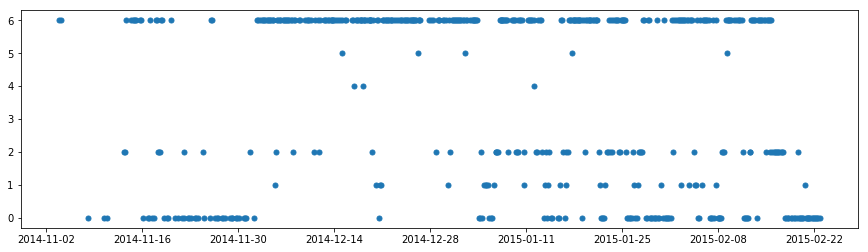

In [5]:
# cais俯瞰

graph = plt.figure(figsize=(15,4))
ax = graph.add_subplot(111)

kilopost_list = df1['_kilopost_sign'].unique()
for i, target_kilopost in enumerate(kilopost_list):

    cais_target = df1[ df1['_kilopost_sign']==target_kilopost ]
    ax.plot(cais_target['_date'], cais_target['cais_road_condition_num'], linestyle='None', marker='.', ms='10')

plt.show()


# 各cais結果に紐づけるデータを引っ張り、df2に格納

In [6]:
#--------------------> 紐付ける気象計を準備
kisho_point = 'HARIUSU'
snow_point = 'ASARI'
kc_point = 'kc_otaru'


#--------------------> ハコを準備
df2 = df1

# caisがNanのものを落とす
print("original data size: ", len(df2.index))
df2 = df2.dropna(axis=0, subset=['cais_road_condition_num'])
df2 = df2.reset_index(drop=True)   # pandas indexを振り直す
print("nan-cais eliminated: ", len(df2.index))


df2['traffic_-1H'] = 0; df2['traffic_-2H'] = 0; df2['traffic_-3H'] = 0

df2['temperature_-1H'] = ""
df2['temperature_-3H'] = ""
df2['rainfall_-1H'] = 0.; df2['rain_continued_-1H'] = 0.;
df2['rainfall_-3H'] = 0.; df2['rain_continued_-3H'] = 0.;
df2['wind_velocity_-1H'] = ""
df2['wind_velocity_-3H'] = ""

df2['snowfall_-1H'] = 0.
df2['snowfall_-3H'] = 0.
df2['snowdepth_-1H'] = 0.
df2['snowdepth_-3H'] = 0.

df2['sunlight_-1H'] = 0.
df2['sunlight_-3H'] = 0.



##########################################


for i in range (len(df2.index)):                        

    #指定過去時間内のデータを呼び出す
    df_tmp3H = df0[ ((df0['_date'] - df2.at[i, '_date'] ) <= datetime.timedelta(hours=0)) 
                  & ((df2.at[i, '_date'] - df0['_date']) <= datetime.timedelta(hours=3)) ]
    
    df_tmp1H = df_tmp3H[ df2.at[i, '_date'] - df_tmp3H['_date'] <= datetime.timedelta(hours=1) ]

    
    #交通量 -> X時間前観測値の実績値
    df_tmp = ned.extract_traffic(df_tmp1H, kilopost, iof)
    df2.at[i, 'traffic_-1H'] = np.sum( df_tmp['tc_traffic_1'] )
    df_tmp = ned.extract_traffic(df_tmp3H, kilopost, iof)
    df2.at[i, 'traffic_-3H'] = np.sum( df_tmp['tc_traffic_1'] )
        
    #NEH気象1H
    df_tmp = df_tmp1H[ df_tmp1H['ws_point_name'] == kisho_point ]
    df2.at[i, 'temperature_-1H'] = np.average( df_tmp['ws_temp_air'] ).round(3).astype('float')
    df2.at[i, 'rainfall_-1H'] = np.sum( df_tmp['ws_rain_time2'] ) 
    df2.at[i, 'rain_continued_-1H'] = np.max( df_tmp['ws_rain_continued'] ) 
    df2.at[i, 'wind_velocity_-1H'] =  np.average( df_tmp['ws_wind_velocity'] ).round(3).astype('float')
        
    #NEH気象3H
    df_tmp = df_tmp3H[ df_tmp3H['ws_point_name'] == kisho_point ]
    df2.at[i, 'temperature_-3H'] = np.average( df_tmp['ws_temp_air'] ).round(3).astype('float') 
    df2.at[i, 'rainfall_-3H'] = np.sum( df_tmp['ws_rain_time2'] ) 
    df2.at[i, 'rain_continued_-3H'] = np.max( df_tmp['ws_rain_continued'] ) 
    df2.at[i, 'wind_velocity_-3H'] =  np.average( df_tmp['ws_wind_velocity'] ).round(3).astype('float')       
    
    #NEH積雪深計   
    df_tmp = df_tmp1H[ df_tmp1H['sd_point_name'] == snow_point ]
    df2.at[i, 'snowfall_-1H'] = np.sum( df_tmp['sd_snow_time'] )
    df2.at[i, 'snowdepth_-1H'] = np.average( df_tmp['sd_snow_depth'] ).round(3).astype('float')
    df_tmp = df_tmp3H[ df_tmp3H['sd_point_name'] == snow_point ]
    df2.at[i, 'snowfall_-3H'] = np.sum( df_tmp['sd_snow_time'] )
    df2.at[i, 'snowdepth_-3H'] = np.average( df_tmp['sd_snow_depth'] ).round(3).astype('float') 
   
    #気象庁データ      
    df_tmp = df_tmp1H[ df_tmp1H['kc_point_name'] == kc_point ]
    df2.at[i, 'sunlight_-1H'] = np.sum( df_tmp['kc_sunlight'] )
    df_tmp = df_tmp3H[ df_tmp3H['kc_point_name'] == kc_point ]
    df2.at[i, 'sunlight_-3H'] = np.sum( df_tmp['kc_sunlight'] )
  
               
    #経過確認
    if i % 200 == 0:
        print( i, "/", len(df2.index))
    
print("finished !!")

original data size:  522
nan-cais eliminated:  517
0 / 517
200 / 517
400 / 517
finished !!


In [7]:
### 除雪および融雪剤の効果をひも付け

df2['josetsu_-1H'] = 0 
df2['event_melt_-3H'] = 0.; #df2['event_melt_-3H_decay'] = 0.
df2['event_melt_-6H'] = 0.; #df2['event_melt_-6H_decay'] = 0.
df2['event_melt_-12H'] = 0.; #df2['event_melt_-12H_decay'] = 0.
df2['event_melt_-24H'] = 0.
df2['event_melt_-36H'] = 0.; df2['event_melt_-36H_decay'] = 0.;


# CAIS散布補正関数--------------------------------------------------------
def mod_melt(dfep_target, cais_prev, cais_prev_JA):    
    
    for i in range(len(dfep_target.index)):
        if dfep_target.at[dfep_target.index[i], 'event_CAIS'] == 'ACA':
            #前回観測値を参照。
            if (cais_prev == 0) or (cais_prev == 5):
                #直後が凍結だったら通常散布。
                if cais_prev_JA != 6:
                    dfep_target.at[dfep_target.index[i], 'event_melt'] = (dfep_target.at[dfep_target.index[i], 'event_melt']*0.5).round(3)
    
    return dfep_target
# -----------------------------------------------------------------------



for i in range (len(df2.index)):  
    
    # イベントデータ(除雪) -> 過去X時間の除雪回数を入れる。
    dfep0_kako = dfep0[ ((dfep0['_date'] - df2.at[i, '_date'] ) <= datetime.timedelta(hours=0)) ]
    dfep0_tmp1H = dfep0_kako[ (df2.at[i, '_date'] - dfep0_kako['_date']) <= datetime.timedelta(hours=1) ]
    
    if len(dfep0_tmp1H.index) != 0:
        df2.at[i, 'josetsu_-1H'] = len(dfep0_tmp1H.dropna(subset=['event_josetsu']).index) 


    # イベントデータ(融雪剤散布) -> 過去X時間
    dfep1_kako = dfep1[ (dfep1['_date'] - df2.at[i, '_date'] ) <= datetime.timedelta(hours=0) ]
    
    dfep1_tmp36H = dfep1_kako[ ((df2.at[i, '_date'] - dfep1_kako['_date']) <= datetime.timedelta(hours=36)) ]
    dfep1_tmp24H = dfep1_tmp36H[ ((df2.at[i, '_date'] - dfep1_tmp36H['_date']) <= datetime.timedelta(hours=24)) ]
    dfep1_tmp12H = dfep1_tmp24H[ ((df2.at[i, '_date'] - dfep1_tmp24H['_date']) <= datetime.timedelta(hours=12)) ]
    dfep1_tmp6H = dfep1_tmp12H[ ((df2.at[i, '_date'] - dfep1_tmp12H['_date']) <= datetime.timedelta(hours=6)) ]
    dfep1_tmp3H = dfep1_tmp6H[ ((df2.at[i, '_date'] - dfep1_tmp6H['_date']) <= datetime.timedelta(hours=3)) ]
    
    if len(dfep1_tmp3H.index) != 0:        
        dfep1_tmp3H = mod_melt(dfep1_tmp3H, df2.at[i, 'cais_prev'], df2.at[i, 'cais_prev_JAK'])
        df2.at[i, 'event_melt_-3H'] = dfep1_tmp3H['event_melt'].sum(axis=0)        

    if len(dfep1_tmp6H.index) != 0:        
        dfep1_tmp6H = mod_melt(dfep1_tmp6H, df2.at[i, 'cais_prev'], df2.at[i, 'cais_prev_JAK'])
        df2.at[i, 'event_melt_-6H'] = dfep1_tmp6H['event_melt'].sum(axis=0)                
    
    if len(dfep1_tmp12H.index) != 0:        
        dfep1_tmp12H = mod_melt(dfep1_tmp12H, df2.at[i, 'cais_prev'], df2.at[i, 'cais_prev_JAK'])
        df2.at[i, 'event_melt_-12H'] = dfep1_tmp12H['event_melt'].sum(axis=0)        
        
    if len(dfep1_tmp24H.index) != 0:        
        dfep1_tmp24H = mod_melt(dfep1_tmp24H, df2.at[i, 'cais_prev'], df2.at[i, 'cais_prev_JAK'])
        df2.at[i, 'event_melt_-24H'] = dfep1_tmp24H['event_melt'].sum(axis=0)        

        
    if len(dfep1_tmp36H.index) != 0:        
        dfep1_tmp36H = mod_melt(dfep1_tmp36H, df2.at[i, 'cais_prev'], df2.at[i, 'cais_prev_JAK'])
        df2.at[i, 'event_melt_-24H'] = dfep1_tmp36H['event_melt'].sum(axis=0)
        dfep1_tmp36H = dfep1_tmp36H.reset_index(drop=True)
        
        for j in range( len(dfep1_tmp36H) ): 
            dfep1_tmp36H.at[j, 'event_melt'] = dfep1_tmp36H.at[j, 'event_melt'] * np.exp( (dfep1_tmp36H.at[j,'_date'] - df2.at[i,'_date'])/datetime.timedelta(hours=12) ) 
            #dfep1_tmp36H.at[j, 'event_melt'] = dfep1_tmp36H.at[j, 'event_melt'] / (1 + np.exp( ( df2.at[i,'_date'] - dfep1_tmp36H.at[j,'_date'] - datetime.timedelta(hours=10))/datetime.timedelta(hours=4)))
            #dfep1_tmp36H.at[j, 'event_melt'] = dfep1_tmp36H.at[j, 'event_melt'] / (1 + np.exp( ( df2.at[i,'_date'] - dfep1_tmp36H.at[j,'_date'] - datetime.timedelta(hours=2))/datetime.timedelta(hours=1))) 
        df2.at[i, 'event_melt_-36H_decay'] = dfep1_tmp36H['event_melt'].sum(axis=0) 
        
        
    #経過確認
    if i % 200 == 0:
        print( i, "/", len(df2.index))
    
print("finished !!")

0 / 517
200 / 517
400 / 517
finished !!


# データ数を調整

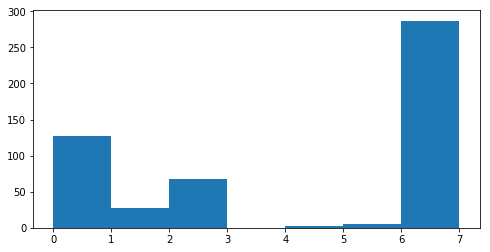

total:  517
dry     :  127
semi-wet:  27
wet     :  68
hydrop  :  0
slash   :  3
fresh   :  5
ice     :  287


In [10]:
# プロットして分布を確認
#df_target = df2[ df2['_kilopost']==kilopost ]
df_target = df2

graph = plt.figure(figsize=(8,4))
ax1 = graph.add_subplot(111)
ax1.hist( df_target['cais_road_condition_num'], bins=7, range=(0,7) )
plt.show()

print("total: ", len(df_target.dropna(subset=['cais_road_condition_num'])))
print("dry     : ", len(df_target[ df_target['cais_road_condition_num']==0 ]),  )
print("semi-wet: ", len(df_target[ df_target['cais_road_condition_num']==1 ]),  )
print("wet     : ", len(df_target[ df_target['cais_road_condition_num']==2 ]),  )
print("hydrop  : ", len(df_target[ df_target['cais_road_condition_num']==3 ]),  )
print("slash   : ", len(df_target[ df_target['cais_road_condition_num']==4 ]),  )
print("fresh   : ", len(df_target[ df_target['cais_road_condition_num']==5 ]),  )
print("ice     : ", len(df_target[ df_target['cais_road_condition_num']==6 ]),  )

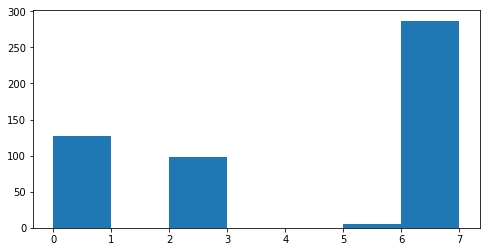

total:  517
dry     :  127
semi-wet:  0
wet     :  98
hydrop  :  0
slash   :  0
fresh   :  5
ice     :  287


In [11]:
df4 = df2

### マイナーデータを変換
df4.loc[  df4['cais_road_condition_num']==1, 'cais_road_condition_num']  = 2
#df4.loc[  df4['cais_prev']==1, 'cais_prev']  = 2
df4.loc[  df4['cais_road_condition_num']==4, 'cais_road_condition_num']  = 2
#df4.loc[  df4['cais_prev']==4, 'cais_prev']  = 2
#df4.loc[  df4['cais_road_condition_num']==5, 'cais_road_condition_num']  = 6
#df4.loc[  df4['cais_prev']==5, 'cais_prev']  = 6


# プロットして分布を確認_その1
df_target = df4

graph = plt.figure(figsize=(8,4))
ax1 = graph.add_subplot(111)
ax1.hist( df_target['cais_road_condition_num'], bins=7, range=(0,7) )
plt.show()

print("total: ", len(df_target.dropna(subset=['cais_road_condition_num'])))
print("dry     : ", len(df_target[ df_target['cais_road_condition_num']==0 ]),  )
print("semi-wet: ", len(df_target[ df_target['cais_road_condition_num']==1 ]),  )
print("wet     : ", len(df_target[ df_target['cais_road_condition_num']==2 ]),  )
print("hydrop  : ", len(df_target[ df_target['cais_road_condition_num']==3 ]),  )
print("slash   : ", len(df_target[ df_target['cais_road_condition_num']==4 ]),  )
print("fresh   : ", len(df_target[ df_target['cais_road_condition_num']==5 ]),  )
print("ice     : ", len(df_target[ df_target['cais_road_condition_num']==6 ]),  )

# 説明変数の統合

In [12]:
from sklearn import metrics, preprocessing
from sklearn.model_selection import *

df_target2 = df4

#----------------------->データ用意   X:説明変数   Y:目的変数(cais_num)
X = df_target2[[#'cais_prev', 
                #'cais_road_temp_prev',
                'traffic_-1H', #'traffic_-3H',
                'temperature_-3H', #'temperature_-3H', #'temperature_-6H', 'temperature_-12H', 
                #'temperature_-24H', 'temperature_-48H', 
                'rainfall_-3H', #'rainfall_-3H',
                'rain_continued_-3H',
                'wind_velocity_-1H', #'wind_velocity_-3H', 

                'snowfall_-3H', #'snowfall_-3H',
                'snowdepth_-1H',
         
                'sunlight_-3H', #'sunlight_-3H',
          
                'josetsu_-1H', 
                'event_melt_-24H', #'event_sol_-6H', 'event_sol_-12H',
                #'event_melt_-36H_decay' 
             ]]

Y = df_target2[['cais_road_condition_num']]


# さらに期間をかけるばあいには、"yyyy-mm-dd"で指定
start = date_start
#start = "2015-12-26"
end = date_end
#end = "2016-2-25" 


# 説明変数を標準化をするか？
scaling_flag = False



###### -----MAIN BODY-----------------------

# マジ時系列データとして扱う。
X.index = df_target2['_date'] 
Y.index = df_target2['_date'] 


print("prepared data size: ", len(Y.index))
# 期間制約
d1 = pd.to_datetime(start)
d2 = pd.to_datetime(end)
X = X[ (d1 < X.index) & (X.index < d2) ]
Y = Y[ (d1 < Y.index) & (Y.index < d2) ]
print("target data size: ", len(Y.index))


# Nanを落とす。
tmp = X.isnull().any(1)
X = X.drop(tmp[tmp==True].index)
Y = Y.drop(tmp[tmp==True].index)
tmp = Y.isnull().any(1)
X = X.drop(tmp[tmp==True].index)
Y = Y.drop(tmp[tmp==True].index) 
X = X.astype('float')
Y = Y.astype('int')
print("final data size: ", len(Y.index))


# 説明変数の標準化
if scaling_flag:
    sc = preprocessing.StandardScaler()
    sc.fit(X)
    X_std = sc.transform(X)
else:
    X_std=X  #スケーリングしない場合はそのまま代入

      
# データをトレーニング用と検証用に分割
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.4)

prepared data size:  517
target data size:  517
final data size:  517


In [15]:
X

,traffic_-1H,temperature_-3H,rainfall_-3H,rain_continued_-3H,wind_velocity_-1H,snowfall_-3H,snowdepth_-1H,sunlight_-3H,josetsu_-1H,event_melt_-24H
_date,,,,,,,,,,
2014-11-03 20:55:05,154.0,2.094,1.0,2.5,3.000,0.8,0.050,0.0,0.0,48.646
2014-11-04 04:55:51,30.0,2.356,0.5,0.5,3.550,0.0,0.033,0.0,0.0,140.353
2014-11-08 05:12:13,37.0,5.383,0.0,0.0,3.033,0.0,0.000,0.0,0.0,0.000
2014-11-10 11:34:31,408.0,9.006,0.0,0.0,2.267,0.0,0.000,0.0,0.0,0.000
2014-11-10 22:12:45,114.0,4.333,0.0,0.0,1.150,0.0,0.083,0.0,0.0,0.000
2014-11-13 10:15:10,399.0,3.689,4.5,4.5,2.567,0.0,0.017,0.0,0.0,0.000
2014-11-13 14:18:42,317.0,2.717,0.0,5.0,2.817,0.0,0.217,0.8,0.0,0.000
2014-11-13 16:04:10,325.0,0.461,1.5,5.5,1.817,5.3,4.600,0.1,0.0,28.000
2014-11-14 08:30:32,522.0,-1.328,0.5,2.0,2.950,0.8,10.500,0.0,0.0,97.720


# stanによる状態推定

In [ ]:
#データの整形 -> 1H毎のデータに整形













In [ ]:
model = 
"""
data
{
    int<lower=2> K;         # クラスの数
    int<lower=0> T;         # 観測数
    int<lower=0> Nmiss;     # 欠損値の数
    int<lower=1> D;         # 外乱変数の数
    
    real    Y[T,K];   # 時系列データ
    real    X[T,D];   # 説明変数マトリックス
}
    
parameters 
{
    real a[K];
    real b[K,D];
    real muZero[1,K];                         # 左端
    vector<lower=0>[Nmiss,K]  Miss_Y;         # 欠測値はパラメータ
    real<lower=0>  s_y[1,K];                  # 観測誤差の大きさ 
    real<lower=0>  s_mu[1,K];                 # 過程誤差の大きさ 
}

transformed parameters
{
    real mu[T,K];
    for (t in 1:T){
        mu[t,:] = a + b * X[t,:]';
    }
}

model
{
    # 事前分布
    mu[1,:] ~ normal(muZero, s_mu);
    mu[2,:] ~ normal(muZero, s_mu);
    
    # 状態方程式->2階差分
    for(t in 3:T) {
        mu[t] ~ normal( 2*mu[t-1] - mu[t-2], s_mu );
    }
       
    # 観測方程式
    int nmiss;
    nmiss = 0;
   
    for(t in 1:T) {
        if(Y[t]!=9999){
            Y[t] ~ categorical_logit( normal( mu[t], s_y) );
        }else{
            # 欠損部分は状態不変
            nmiss = nmiss+1;
            Miss_Y[nmiss] ~ categorical_logit( normal( mu[t], s_y) );
        }
    }    
}
"""

In [ ]:
fit = pystan.stan(
                    model_code=model, 
                    data={'K':3, 'T':600, 'Nmiss':50, 'D':10, 'X':X_std, 'Y':Y}, 
                    iter=10000, 
                    chains=3
                 )
fit

In [ ]:
la = fit.extract()
 
pred = la['mu'].mean(axis=0)
mu_lower, mu_upper = np.percentile(la['mu'], q=[2.5, 97.5], axis=0)
 
plt.plot(list(range(len(y)+1)), list(y)+[None], color='black')
plt.plot(list(range(1, len(y)+1)), pred)
plt.fill_between(list(range(1, len(y)+1)), mu_lower, mu_upper, alpha=0.3)
plt.show()

# 可視化

/home/bridgestone-forest/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


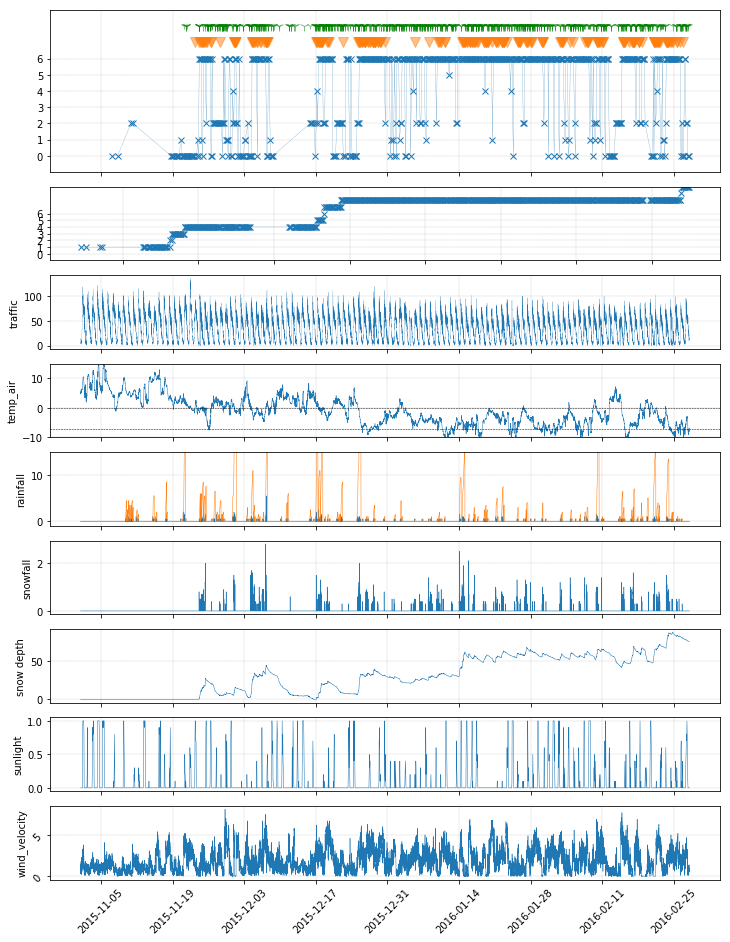

In [15]:
#%matplotlib notebook
%matplotlib inline


# 全体を眺める
# ---------------> 
target_df0   = df0
target_df1   = df1
target_cais  = df3
target_dfep0 = dfep0
target_dfep1 = dfep1



graph = plt.figure(figsize=(12,16))
num_row = 10

### cais生データ + event
ax1 = graph.add_subplot(num_row,1,(1,2))
ax1.plot(target_df1['_date'], target_df1['cais_road_condition_num'], linestyle='solid', linewidth=0.2, marker='x')
ax1.set_ylim( -1, 9 )
ax1.set_yticks( np.arange(7) )
ax1.grid(linestyle='--', linewidth=0.1, color='black')
ax1.tick_params(labelbottom="off")

### 除雪イベントの追記
ax1.plot(target_dfep0['_date'], target_dfep0['cais_num_josetsu'], 'v', ms='10', alpha=0.5, label='josetsu' )


### 融雪剤散布イベントの追記
for i in range(len(target_dfep1)):
    ax1.plot( target_dfep1.at[i, '_date'], 8, marker='1', ms=target_dfep1.at[i, 'event_melt']-10, alpha=0.5, color='g' )         

    
### 隠れ状態
ax2 = graph.add_subplot(num_row,1,3)
ax2.plot(df3h['_date'], df3h['hidden_states'], linestyle='solid', linewidth=0.2, marker='x')
ax2.set_ylim( -1, 10 )
ax2.set_yticks( np.arange(7) )
ax2.grid(linestyle='--', linewidth=0.1, color='black')
ax2.tick_params(labelbottom="off")

    
                    
### 交通量
#Usage -> plot_traffic(ax, df, kilopost, iof, lane, line_color, data_label)
ax3 = graph.add_subplot(num_row,1,4, sharex=ax1)
plot_traffic(ax3, target_df0, kilopost, iof, '1', 'traffic')
ax3.set_ylabel("traffic")
ax3.grid(linestyle='--', linewidth=0.1, color='black')
ax3.tick_params(labelbottom="off")


'''
### cais路温計
ax3 = graph.add_subplot(num_row,1,4, sharex=ax1) 
ax3.plot(target_cais ['_date'], target_cais['cais_road_temp'], linestyle='solid', linewidth=0.2, marker='.')
ax3.set_ylim(-10, 15)
ax3.set_ylabel("road_temp")
ax3.axhline(y=0, linestyle='dashed', linewidth=0.5, color='k')
ax3.grid(linestyle='--', linewidth=0.1, color='black')
ax3.tick_params(labelbottom="off")            
'''

### 気象など
#Usage -> plot_kisho(ax, df, colum, wsn, line_color, data_label)
ax4 = graph.add_subplot(num_row,1,5, sharex=ax1) 
#plot_kisho(ax5, df0, 'kc_temperature', 'kc_otaru', 'r', 'temperature')
plot_kisho(ax4, target_df0, 'ws_temp_air', kisho_point, 'temp')
ax4.set_ylabel("temp_air")
ax4.axhline(y=0, linestyle='dashed', linewidth=0.5, color='k')
ax4.axhline(y=-7, linestyle='dashed', linewidth=0.5, color='k')
ax4.set_ylim(-10, 15)
ax4.grid(linestyle='--', linewidth=0.1, color='black')
ax4.tick_params(labelbottom="off")

ax5 = graph.add_subplot(num_row,1,6, sharex=ax1) 
plot_kisho(ax5, target_df0, 'ws_rain_time2', kisho_point, 'rainfall')
plot_kisho(ax5, target_df0, 'ws_rain_continued', kisho_point, 'rainfall')
ax5.set_ylabel("rainfall")
ax5.grid(linestyle='--', linewidth=0.1, color='black')
ax5.set_ylim( -1, 15 )
ax5.tick_params(labelbottom="off")

ax6 = graph.add_subplot(num_row,1,7, sharex=ax1) 
plot_kisho(ax6, target_df0, 'sd_snow_time', snow_point, 'snowfall')
ax6.set_ylabel("snowfall")
ax6.grid(linestyle='--', linewidth=0.1, color='black')
ax6.tick_params(labelbottom="off")

ax7 = graph.add_subplot(num_row,1,8, sharex=ax1) 
plot_kisho(ax7, target_df0, 'sd_snow_depth', snow_point, 'snow depth')
ax7.set_ylabel("snow depth")
ax7.grid(linestyle='--', linewidth=0.1, color='black')
ax7.tick_params(labelbottom="off")

ax8 = graph.add_subplot(num_row,1,9, sharex=ax1) 
plot_kisho(ax8, target_df0, 'kc_sunlight', kc_point, 'sunlight')
ax8.set_ylabel("sunlight")
ax8.grid(linestyle='--', linewidth=0.1, color='black')
ax8.tick_params(labelbottom="off")


ax9 = graph.add_subplot(num_row,1,10, sharex=ax1)
plot_kisho(ax9, target_df0, 'ws_wind_velocity', kisho_point, 'wind')
ax9.set_ylabel("wind_velocity")
ax9.grid(linestyle='--', linewidth=0.1, color='black')
ax9.tick_params(rotation=45)



#path2fig = os.path.join(folder_data, "2015_HMM.png")
path2fig = "2015_HMM.jpg"
graph.savefig(path2fig, dpi=600)

plt.show()